The paper where LASSO came from dictated its name to be pronounced as "Lassu", which is an interesting fact to me.

In [50]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd

In [62]:
df_temp = pd.read_csv("./airbnb_attractions2.csv")
missing_values_per_column = df_temp.isnull().sum()
print(missing_values_per_column)

id                                  0
last_scraped                        0
neighbourhood                    8050
neighbourhood_cleansed              0
neighbourhood_group_cleansed    19764
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                       22305
bathrooms_text                      6
bedrooms                        22301
beds                              408
price                            2088
has_availability                 2088
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
number_of_reviews_ltm               0
number_of_reviews_l30d              0
review_scores_rating                0
review_scores_accuracy              1
review_scores_cleanliness           1
review_score

/tmp/ipykernel_5845/2944115560.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("./airbnb_attractions2.csv")


In [1]:
# Extract numeric value from 'bathrooms_text' and handle special cases
# This function and the data preprocessing function were borrowed from Peter's.
def extract_bathrooms(text):
    if pd.isnull(text):
        return np.nan
    if 'half-bath' in text.lower():
        return 0.5
    numbers = pd.to_numeric(pd.Series(text).str.extract('(\d+\.?\d*)')[0], errors='coerce')
    if numbers.empty:
        return np.nan
    return numbers.iloc[0]

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_5558/992609072.py:8: SyntaxWarning: invalid escape sequence '\d'
  numbers = pd.to_numeric(pd.Series(text).str.extract('(\d+\.?\d*)')[0], errors='coerce')


In [2]:
def process_data(path="./airbnb_attractions2.csv"):
    # remove has availability + empty price (since these can't help us)
    # remove empty review records since not so many
    # remove columns bedrooms, bathrooms
    # remove neighbourhood_group_cleansed
    df = pd.read_csv(path)
    
    df = df.dropna(subset=['has_availability', 'price'])
    
    review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                      'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                      'review_scores_value']
    df = df.dropna(subset=review_columns)
    
    df = df.drop(columns=['bedrooms', 'bathrooms', 'neighbourhood_group_cleansed', 'neighbourhood'])
    
    df = df.dropna(subset=['bathrooms_text', 'beds'])


    # 1. drop column last_scraped, # drop property_type, neighbourhood_cleansed
    df = df.drop(columns=['last_scraped', 'property_type', 'neighbourhood_cleansed'])
    
    # 2. One-hot encode 'room_type'
    df = pd.get_dummies(df, columns=['room_type'], drop_first=False)
    
    # 3. Process 'bathrooms_text'
    # Create shared_bathroom indicator
    df['shared_bathroom'] = df['bathrooms_text'].str.contains('shared').astype(int)
    
    # Apply the corrected function
    df['bathrooms'] = df['bathrooms_text'].apply(extract_bathrooms)
    
    # Ensure we handle any potential issues with NaN values correctly
    df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
    
    # Continue with the rest of your preprocessing
    df = df.drop(columns=['bathrooms_text'])
    
    # 4. Convert 'has_availability'
    df['has_availability'] = df['has_availability'].map({'t': 1, 'f': 0})
    
    # 5. Encode 'city' with numeric identifiers (e.g., Toronto=1, Sydney=2, Barcelona=3)
    city_mapping = {'Toronto': 1, 'Sydney': 2, 'Barcelona': 3}
    df['city_id'] = df['city'].map(city_mapping)
    # print(df.head())
        
    df = df.drop(columns=['city'])
    df['price'] = df['price'].str.replace('[^0-9.]', '', regex=True).astype('float64')
    # Transform price into its natural-log version for residual normality
    df['logged_price'] = np.log(df['price'])
    return df
    

In [140]:
def run_lasso(df, predictors, target='logged_price', normalize=False, dataset_name='Dataset'):
    # BORROWED AND ADAPTED FROM PETER'S CODE
    # Check for missing columns
    missing_columns = [col for col in predictors + [target] if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")
        
    # Prepare predictors and target variables
    X = df[predictors]
    y = df[target]
    X_cols = X.columns
    X_index = X.index
    
    # Impute data because we have missing values here aaaaa so that it can work SKLEARN's REGRESSION
    imputer = KNNImputer(weights="uniform") # Maybe go distance for each weight???
    # Might have to extract price here for supervised imputation? But...wouldn't that cause bias in the regression?
    X = pd.DataFrame(data=imputer.fit_transform(X=X), columns=X_cols, index=X_index)
    
    # Normalize features column-wise.
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
        
    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    # Fit the LASSO regression.
    lasso_CV = LassoCV(cv=10, random_state=0) # Lasso with cross-validation at each alpha hyperparameter!
    lasso_CV.fit(X_train, y_train)

    print(f"Best alpha value: {lasso_CV.alpha_}")
    lasso_best = Lasso(alpha=lasso_CV.alpha_)
    lasso_best.fit(X_train, y_train)

    # # Print results
    print("\nSignificant predictors and their coefficients:")
    coeff_col = list(zip(lasso_best.coef_, X))
    for (coeffs, col) in coeff_col:
        print(f"{col}: {coeffs}")
    print(f"R squared training set: {round(lasso_best.score(X_train, y_train), 2)}")
    print(f"R squared test set: {round(lasso_best.score(X_test, y_test), 2)}")
    print(f"Final Train MSE: {mean_squared_error(y_train, lasso_best.predict(X_train))}")
    print(f"Test MSE: {mean_squared_error(y_test, lasso_best.predict(X_test))}")
    
    # Draw the MSE error at each alpha alongside the average MSE of all fold at a particular alpha.
    fig, ax = plt.subplots()
    ax.semilogx(lasso_CV.alphas_, lasso_CV.mse_path_, ":")
    ax.plot(
        lasso_CV.alphas_ ,
        lasso_CV.mse_path_.mean(axis=-1),
        "k",
        label="Average across the folds",
        linewidth=2,
    )
    ax.axvline(
        lasso_CV.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
    )
    
    ax.legend()
    ax.set_xlabel("alphas")
    ax.set_ylabel("Mean square error")
    ax.set_title("Mean square error on each fold")
    ax.axis("tight")

    ymin, ymax = 0.15, 0.5
    ax.set_ylim(ymin, ymax);
    
    fig, ax = plt.subplots()
    alphas = np.linspace(0.0,10,200)
    lasso = Lasso()
    coefs = []

    # Plot trace of coefficients of each column
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X_train, y_train)
        coefs.append(lasso.coef_)
    
    ax = plt.gca()
    ax.axvline(
        lasso_CV.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
    )
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.axis('tight')
    ax.legend()
    ax.set_xlabel('alpha')
    ax.set_ylabel('Standardized Coefficients')
    ax.set_title(f'Lasso coefficients as a function of alpha in {dataset_name}');
    plt.savefig(f"LASSO_trace_{dataset_name}")
    
    # Plots for comparing the prices with the LASSO-predicted one.
    fig, ax = plt.subplots(1, figsize=(15, 5))
    predicted = lasso_best.predict(X)
    predicted_price = np.exp(predicted);
    # draw sth here....
    num_listing = [i for i in range(0, y.shape[0])]
    ax.plot(num_listing, df["price"], label="Original Price")
    ax.plot(num_listing, predicted_price, label="Predicted Price")
    ax.set_title("Original price vs predicted price")
    ax.set_xlabel("Listing No.")
    ax.set_ylabel("Price")
    ax.legend()    
    return

In [136]:
# Borrowed from Peter's. THIS IS TO MAINTAIN CONSISTENCY!!!
# wait, why would we need id for? isn't it just for database stuff? 
# same goes for city_id too considering we have the longitude and latitude I think...
# Anyways, we have to experiment which column to include...
objective_columns_original = [
    'latitude', 'longitude',
    'accommodates', 'beds',
    'has_availability', 'availability_30', 'availability_60', 'availability_90',
    'availability_365', 'distance_to_attraction', 'distance_to_largest',
    'room_type_Entire home/apt', 'room_type_Hotel room',
    'room_type_Private room', 'room_type_Shared room',
    'shared_bathroom', 'bathrooms']
objective_columns = [
    'latitude', 'longitude',
    'accommodates', 'beds',
    'has_availability', 'availability_30', 'availability_60', 'availability_90',
    'availability_365',
    'room_type_Entire home/apt', 'room_type_Hotel room',
    'room_type_Private room', 'room_type_Shared room',
    'shared_bathroom', 'bathrooms']


all_columns = ['id', 'latitude', 'longitude', 'accommodates', 'beds', 
               'has_availability', 'availability_30', 'availability_60', 'availability_90', 
               'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
               'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
               'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 
               'mean_sentiment', 'distance_to_attraction', 'attraction_reviews', 'room_type_Entire home/apt', 'room_type_Hotel room', 
               'room_type_Private room', 'room_type_Shared room', 'shared_bathroom', 'bathrooms', 'city_id']

In [137]:
df = process_data()

# Split into 6 datasets: by city: Toronto, Barcelona, Sydney – objective and all columns
# Columns for the 'objective' dataset
df_toronto_all = df[df['city_id'] == 1]
print("Toronto df done")
df_sydney_all = df[df['city_id'] == 2]
print("Sydney df done")
df_barcelona_all = df[df['city_id'] == 3]
print("Barcelona df done")
all_columns = df.drop(['price'], axis=1).columns.tolist()  # Exclude 'price' from predictors

/tmp/ipykernel_5845/3207777687.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Toronto df done
Sydney df done
Barcelona df done


In [120]:
# Example calls for each dataset with 'all' columns. Again, borrowed from Peter's and modified accordingly.
# run_lasso(df_toronto_all, all_columns, normalize=True, dataset_name='Toronto All')
# run_lasso(df_sydney_all, all_columns, normalize=True, dataset_name='Sydney All')
# run_lasso(df_barcelona_all, all_columns, normalize=True, dataset_name='Barcelona All')

# I think the absurd cross-fold mse errors are due to some of the airbnb listings being way more expensive than others....

# Assuming 'objective_columns' is defined elsewhere and excludes 'price'
# run_lasso(df_toronto_all, objective_columns, normalize=True, dataset_name='Toronto Objective')

Best alpha value: 0.00042124472033178265

Significant predictors and their coefficients:
latitude: 0.006601167107324733
longitude: 0.004380466632052349
accommodates: 0.2284290044764463
beds: 0.01778635861368962
has_availability: 0.00141568649039101
availability_30: 0.14752433573023602
availability_60: -0.11016714405416819
availability_90: 0.036985846222569105
availability_365: -0.015539661618602374
distance_to_attraction: 0.01549816156152273
distance_to_largest: -0.17333942476031422
room_type_Entire home/apt: 0.1472489670433057
room_type_Hotel room: 0.0
room_type_Private room: -0.0
room_type_Shared room: -0.012116915870688217
shared_bathroom: -0.11172073416268885
bathrooms: 0.09026880172610582
R squared training set: 0.52
R squared test set: 0.55
Final Train MSE: 0.24714407432801858
Test MSE: 0.25307055283270247


/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e+03, tolerance: 4.230e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV inste

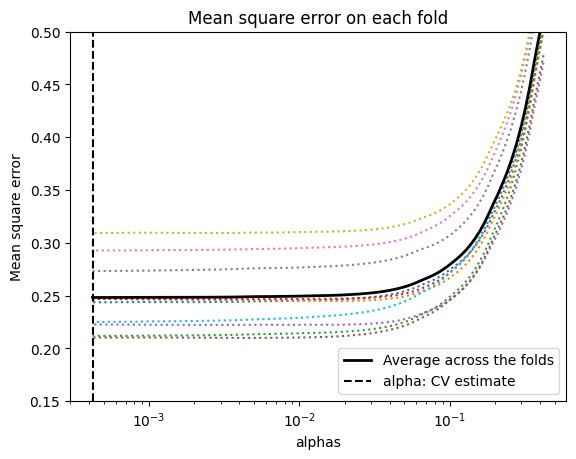

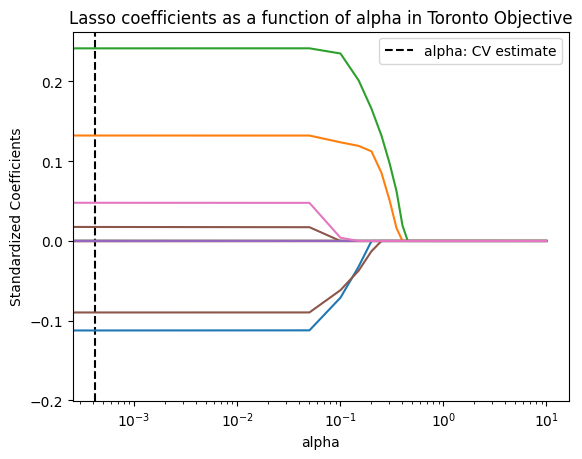

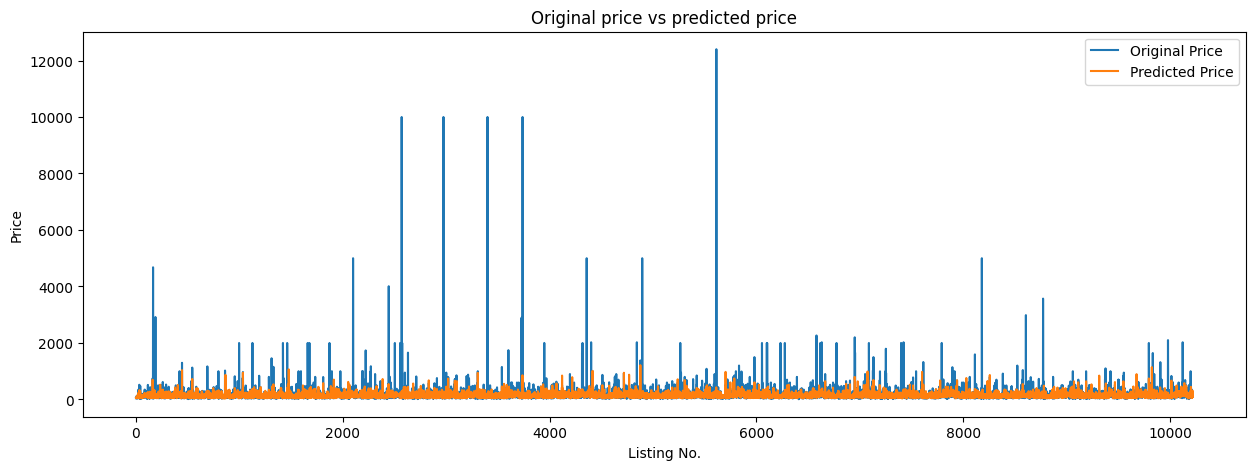

In [141]:
run_lasso(df_toronto_all, objective_columns_original, normalize=True, dataset_name='Toronto Objective')

In [122]:
# run_lasso(df_sydney_all, objective_columns, normalize=True, dataset_name='Sydney Objective')

Best alpha value: 0.0005434148842902082

Significant predictors and their coefficients:
latitude: 0.009694589599366938
longitude: 0.24086825699366718
accommodates: 0.29078875339307214
beds: 0.010999781520693135
has_availability: 0.17002086031953162
availability_30: 0.00949642958289256
availability_60: 0.12269917477496667
availability_90: -0.07923532752490105
availability_365: 0.04920423816188814
distance_to_attraction: 0.03448797796656296
distance_to_largest: 0.011831220655670858
room_type_Entire home/apt: 0.14262148181929926
room_type_Hotel room: 0.050057517622169034
room_type_Private room: -0.0491548149543676
room_type_Shared room: -0.04137414707358721
shared_bathroom: -0.10893424440500385
bathrooms: 0.1269960160418929
R squared training set: 0.68
R squared test set: 0.68
Final Train MSE: 0.23691390139604196
Test MSE: 0.21899184790179926


/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.089e+02, tolerance: 4.392e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV inste

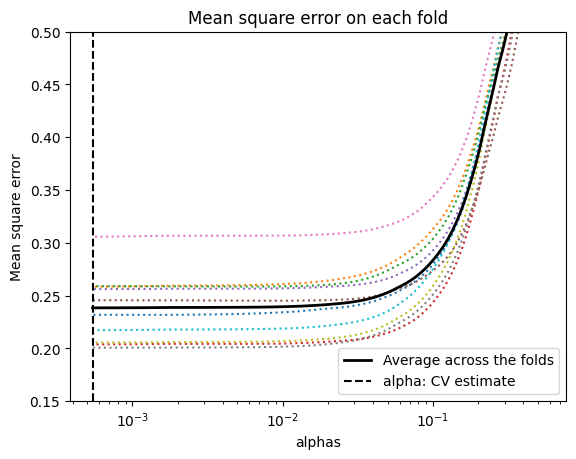

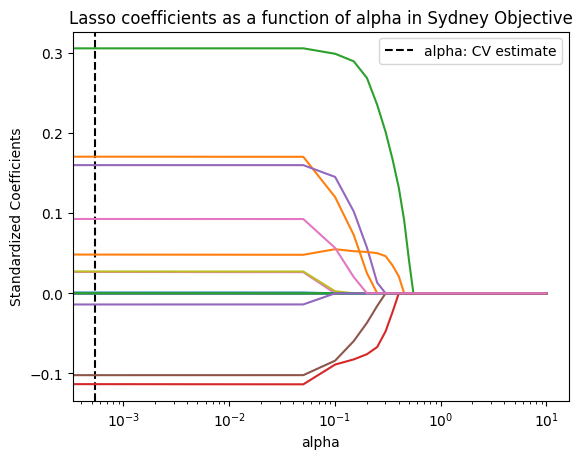

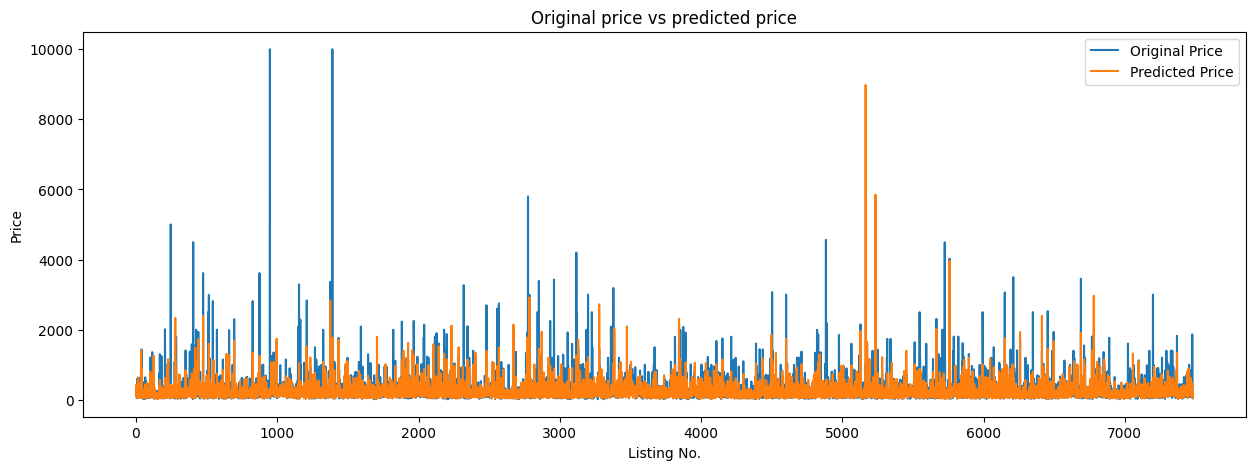

In [145]:
run_lasso(df_sydney_all, objective_columns_original, normalize=True, dataset_name='Sydney Objective')

In [124]:
# run_lasso(df_barcelona_all, objective_columns, normalize=True, dataset_name='Barcelona Objective')

Best alpha value: 0.0011869852578886835

Significant predictors and their coefficients:
latitude: -0.1274073128049874
longitude: -0.06943366255335301
accommodates: 0.29502068346186033
beds: 0.0
has_availability: -0.03792045050001735
availability_30: 0.010199918392674628
availability_60: 0.09282440932401931
availability_90: 0.07464982650850403
availability_365: -0.12229948626679929
distance_to_attraction: 0.08083100106389834
distance_to_largest: -0.12774587996146788
room_type_Entire home/apt: 0.0
room_type_Hotel room: 0.045902352358579986
room_type_Private room: -0.05270790059215848
room_type_Shared room: -0.09668427742069714
shared_bathroom: -0.18541148804875504
bathrooms: 0.06752502793737736
R squared training set: 0.5
R squared test set: 0.57
Final Train MSE: 0.2710679038683547
Test MSE: 0.231899914199382


/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e+02, tolerance: 9.267e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV inste

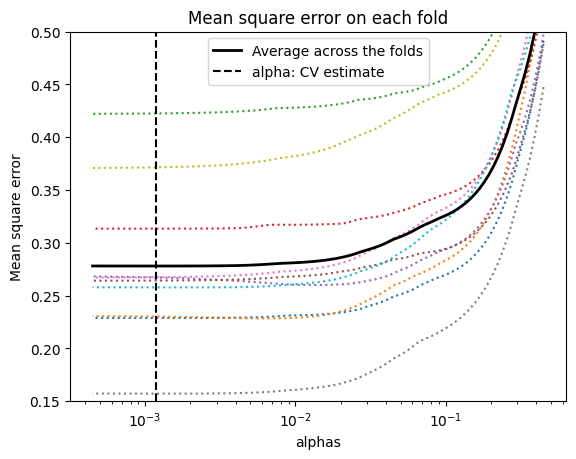

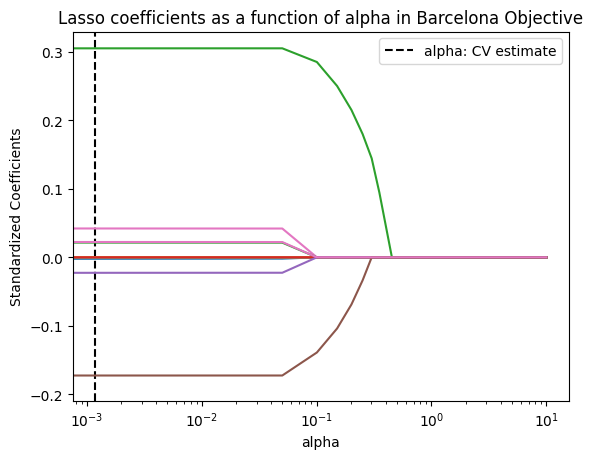

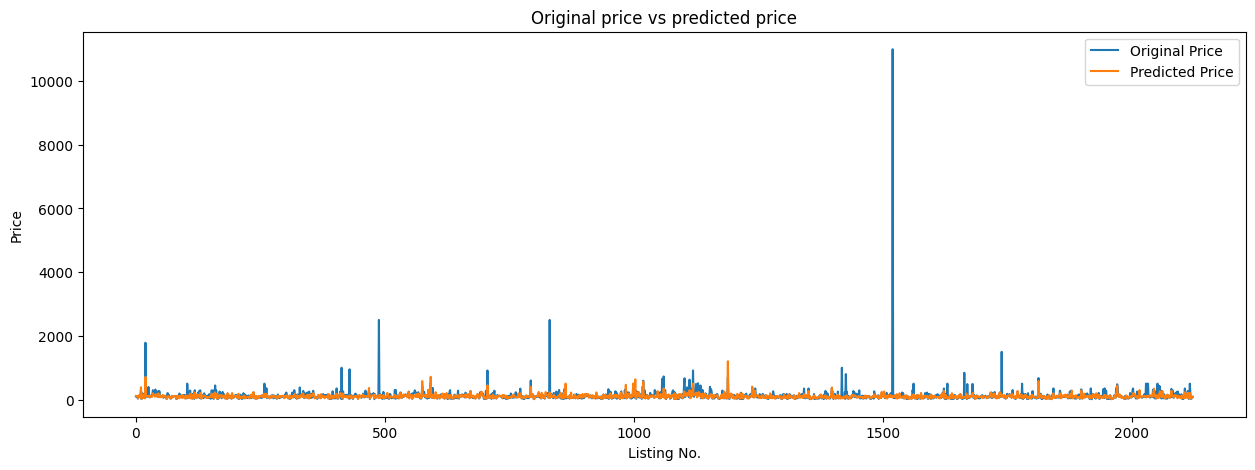

In [146]:
run_lasso(df_barcelona_all, objective_columns_original, normalize=True, dataset_name='Barcelona Objective')

Ridge Regression time. 

In [131]:
def run_ridge(df, predictors, target='logged_price', normalize=False, dataset_name='Dataset'):
    # BORROWED AND ADAPTED FROM PETER'S CODE
    # Check for missing columns
    missing_columns = [col for col in predictors + [target] if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")

    # Prepare predictors and target variables
    X = df[predictors]
    y = df[target]
    X_cols = X.columns
    X_index = X.index
    
    # Impute data because we have missing values here aaaaa so that it can work SKLEARN's REGRESSION
    imputer = KNNImputer(weights="uniform") # Maybe go distance for each weight???
    # Might have to extract price here for supervised imputation? But...wouldn't that cause bias in the regression?
    X = pd.DataFrame(data=imputer.fit_transform(X=X), columns=X_cols, index=X_index)
    
    # Normalize features column-wise.
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
        
    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    # Fit the ridge regression.
    alphas = np.linspace(0.01,1000,100)
    ridge_CV = RidgeCV(alphas=alphas, cv=10) # Lasso with cross-validation at each alpha hyperparameter!
    ridge_CV.fit(X_train, y_train)

    print(f"Best alpha value: {ridge_CV.alpha_}")
    ridge_best = Ridge(alpha=ridge_CV.alpha_)
    ridge_best.fit(X_train, y_train)

    # # Print results
    print("\nSignificant predictors and their coefficients:")
    coeff_col = list(zip(ridge_best.coef_, X))
    for (coeffs, col) in coeff_col:
        print(f"{col}: {coeffs}")
    print(f"R squared training set: {round(ridge_best.score(X_train, y_train), 2)}")
    print(f"R squared test set: {round(ridge_best.score(X_test, y_test), 2)}")
    print(f"Final Train MSE: {mean_squared_error(y_train, ridge_best.predict(X_train))}")
    print(f"Test MSE: {mean_squared_error(y_test, ridge_best.predict(X_test))}")

    # Plots for comparing the prices with the Ridge-predicted one.
    fig, ax = plt.subplots(1, figsize=(15, 5))
    predicted = ridge_best.predict(X)
    predicted_price = np.exp(predicted);
    # draw sth here....
    num_listing = [i for i in range(0, y.shape[0])]
    ax.plot(num_listing, df["price"], label="Original Price")
    ax.plot(num_listing, predicted_price, label="Predicted Price")
    ax.set_title("Original price vs predicted price")
    ax.set_xlabel("Listing No.")
    ax.set_ylabel("Price")
    ax.legend()
    return

Best alpha value: 10.110909090909091

Significant predictors and their coefficients:
latitude: 0.00781306825285581
longitude: 0.005502037003943769
accommodates: 0.2270145833217421
beds: 0.01897293451033591
has_availability: 0.001790864114943686
availability_30: 0.15545864422106292
availability_60: -0.13251471367997322
availability_90: 0.052978371740420416
availability_365: -0.016989021900183088
distance_to_attraction: 0.019241707434843124
distance_to_largest: -0.1780024994759122
room_type_Entire home/apt: 0.07551466147262105
room_type_Hotel room: 0.0
room_type_Private room: -0.07190703397697597
room_type_Shared room: -0.024126732565873325
shared_bathroom: -0.11167286583693643
bathrooms: 0.09065255866188787
R squared training set: 0.52
R squared test set: 0.55
Final Train MSE: 0.24711155269180266
Test MSE: 0.2530936150211428


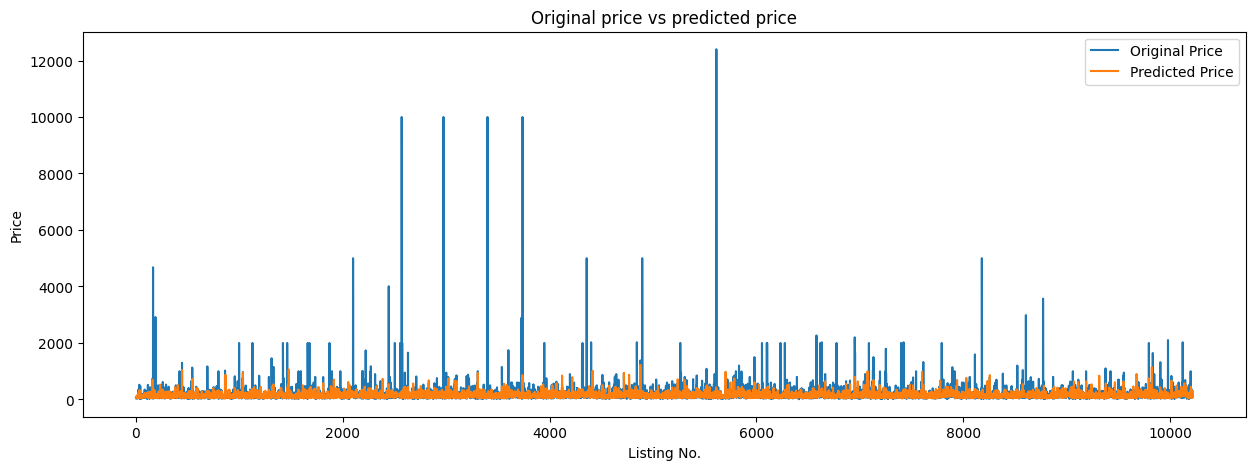

In [132]:
run_ridge(df_toronto_all, objective_columns_original, normalize=True, dataset_name='Toronto Objective')


Best alpha value: 10.110909090909091

Significant predictors and their coefficients:
latitude: 0.009875231475473404
longitude: 0.24133203523450272
accommodates: 0.2882414237616403
beds: 0.012965222266980856
has_availability: 0.17017382389343308
availability_30: 0.008483683346864529
availability_60: 0.14185899134419844
availability_90: -0.09907069711402904
availability_365: 0.05115375176384772
distance_to_attraction: 0.03436885231830463
distance_to_largest: 0.013162535904291232
room_type_Entire home/apt: 0.09433856382280835
room_type_Hotel room: 0.03865644465742196
room_type_Private room: -0.09684507115202592
room_type_Shared room: -0.05066803692620735
shared_bathroom: -0.10900149458649458
bathrooms: 0.12728289924065903
R squared training set: 0.68
R squared test set: 0.68
Final Train MSE: 0.23688308816198764
Test MSE: 0.21899716047782233


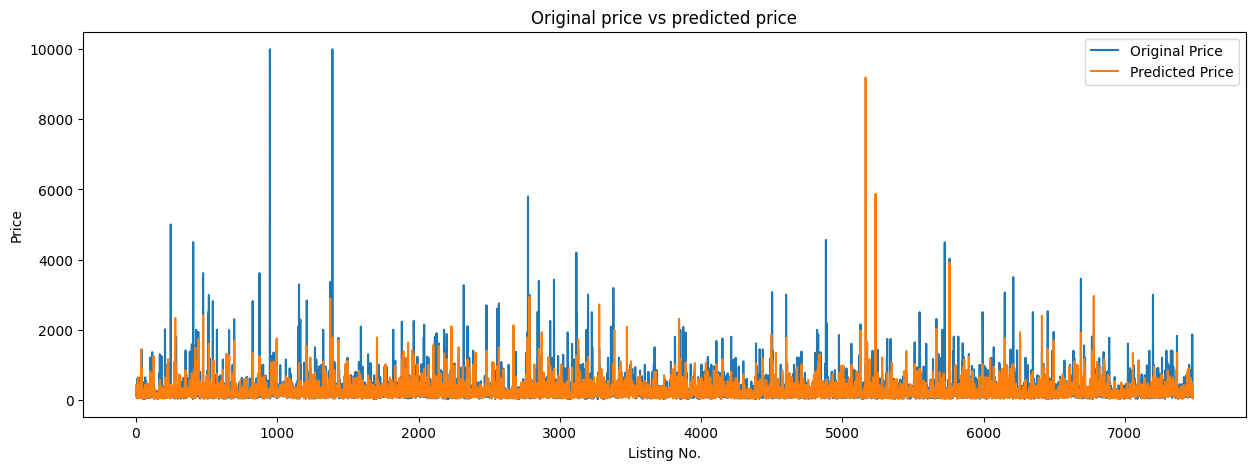

In [133]:
run_ridge(df_sydney_all, objective_columns_original, normalize=True, dataset_name='Sydney Objective')


Best alpha value: 20.211818181818185

Significant predictors and their coefficients:
latitude: -0.1266020686568465
longitude: -0.07002895408380325
accommodates: 0.2817081388181663
beds: 0.009730275370455193
has_availability: -0.038760544908011195
availability_30: 0.014847888818352546
availability_60: 0.08437934858444258
availability_90: 0.07984663261850532
availability_365: -0.12233157223066128
distance_to_attraction: 0.0807315160215624
distance_to_largest: -0.12822222687935603
room_type_Entire home/apt: 0.03029411951869853
room_type_Hotel room: 0.05831990514347315
room_type_Private room: -0.03071230554151094
room_type_Shared room: -0.0920472353785826
shared_bathroom: -0.18166214815287007
bathrooms: 0.06913605613387107
R squared training set: 0.5
R squared test set: 0.56
Final Train MSE: 0.27111089750023815
Test MSE: 0.23233260691779498


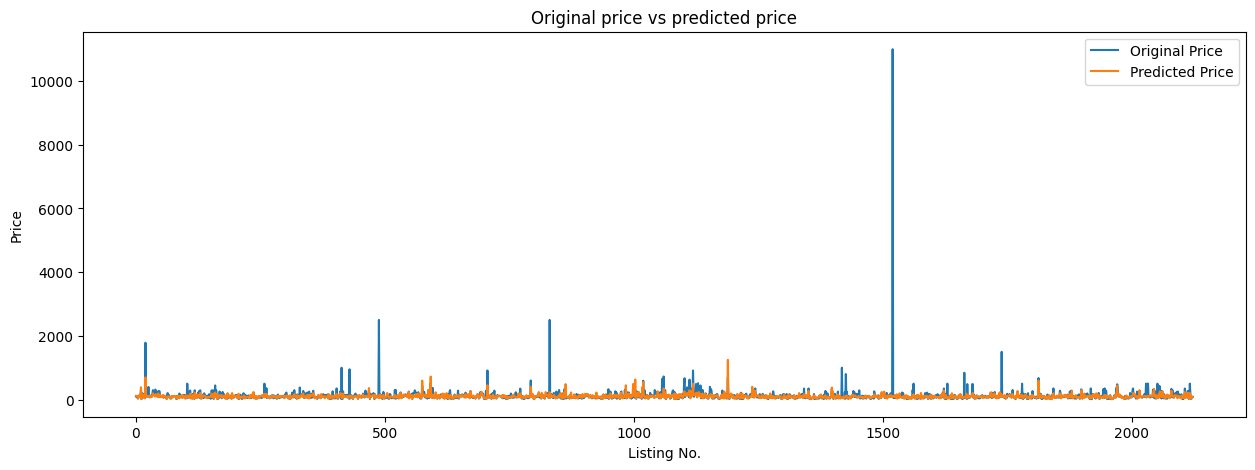

In [134]:
run_ridge(df_barcelona_all, objective_columns_original, normalize=True, dataset_name='Barcelona Objective')